# Load ECMWF data

> Requires `[ecmwf]` optional dependencies:
>
> ```
> $ pip install pycontrails[ecmwf]
> ```

Support provided for:

- [ERA5](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5) via the [Copernicus Data Store (CDS)](https://cds.climate.copernicus.eu/) using [cdsapi](https://github.com/ecmwf/cdsapi) or user provided files
- [HRES](https://confluence.ecmwf.int/display/FUG/Section+2.1.1.2+Rationale+for+High+Resolution) and [ENS](https://confluence.ecmwf.int/display/FUG/Section+2.1.2.1+ENS+-+Ensemble+Forecasts) via [MARS](https://confluence.ecmwf.int/display/UDOC/MARS+user+documentation) using [ecmwf-api-client](https://github.com/ecmwf/ecmwf-api-client) or user provided files.

For both ERA5 and HRES, we provide interfaces for accessing "pressure-level data" (fields pre-interpolated to a fixed set of pressure levels) or "model-level data" (fields retrieved on the native vertical grid and [interpolated after retrieval to an arbitrary set of pressure levels](model-levels.ipynb)). We recommend using model-level data when possible, as the resolution of pressure-level data is coarse relative to the vertical scale of ice-supersaturated regions.

**Note that tools for accessing ECMWF data are not thoroughly tested in CI because they are vulnerable to upstream failures in external APIs.** If you think you have found a problem please [open an issue](https://github.com/contrailcirrus/pycontrails/issues)!

## ERA5

### Access

- Requires account with [Copernicus Data Portal](https://cds.climate.copernicus.eu/cdsapp#!/home)
- Provide `url` and `key` credentials on input, or refer to the [CDS API Documentation](https://github.com/ecmwf/cdsapi#configure) for how to create `~/.cdsapirc` file to configure access.

### Reference

- [ERA 5 Data Documentation](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation)
- [ERA5 Parameter Listing](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Parameterlistings)

### ERA5 Pressure Levels

- [ERA5 Pressure Level Parameters](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Table9)

In [1]:
from pycontrails.datalib.ecmwf import ERA5

In [2]:
# get a single time
era5 = ERA5(
    time="2022-03-01 00:00:00",
    variables=["t", "q", "u", "v", "w", "ciwc", "z", "cc"],  # supports CF name or short names
    pressure_levels=[200, 250, 300],
    # url="https://cds.climate.copernicus.eu/api/v2",
    # key="<key>"
)
era5

ERA5
	Timesteps: ['2022-03-01 00']
	Variables: ['t', 'q', 'u', 'v', 'w', 'ciwc', 'z', 'cc']
	Pressure levels: [200, 250, 300]
	Grid: 0.25
	Dataset: reanalysis-era5-pressure-levels
	Product type: reanalysis

In [3]:
# get a range of time and all available pressure levels between 450 and 125 hPa
era5 = ERA5(
    time=("2022-03-01 00:00:00", "2022-03-01 03:00:00"),
    variables=[
        "air_temperature",
        "q",
        "u",
        "v",
        "w",
        "ciwc",
        "z",
        "cc",
    ],  # supports CF name or short names
    pressure_levels=[125, 150, 175, 200, 225, 250, 300, 350, 400, 450],
    # url="https://cds.climate.copernicus.eu/api/v2",
    # key="<key>"
)
era5

ERA5
	Timesteps: ['2022-03-01 00', '2022-03-01 01', '2022-03-01 02', '2022-03-01 03']
	Variables: ['t', 'q', 'u', 'v', 'w', 'ciwc', 'z', 'cc']
	Pressure levels: [125, 150, 175, 200, 225, 250, 300, 350, 400, 450]
	Grid: 0.25
	Dataset: reanalysis-era5-pressure-levels
	Product type: reanalysis

In [4]:
# this triggers a download from CDS if file isn't in cache store
met_pl = era5.open_metdataset()
met_pl

MetDataset with data:

<xarray.Dataset> Size: 3GB
Dimensions:                              (longitude: 1440, latitude: 721,
                                          level: 10, time: 4)
Coordinates:
  * latitude                             (latitude) float64 6kB -90.0 ... 90.0
  * level                                (level) float64 80B 125.0 ... 450.0
  * time                                 (time) datetime64[ns] 32B 2022-03-01...
  * longitude                            (longitude) float64 12kB -180.0 ... ...
    air_pressure                         (level) float64 80B 1.25e+04 ... 4.5...
    altitude                             (level) float64 80B 1.476e+04 ... 6....
Data variables:
    air_temperature                      (longitude, latitude, level, time) float64 332MB dask.array<chunksize=(1440, 721, 10, 1), meta=np.ndarray>
    specific_humidity                    (longitude, latitude, level, time) float64 332MB dask.array<chunksize=(1440, 721, 10, 1), meta=np.ndarray>
    eastward_wind                        (longitude, latitude, level, time) float64 332MB dask.array<chunksize=(1440, 721, 10, 1), meta=np.ndarray>
    northward_wind                       (longitude, latitude, level, time) float64 332MB dask.array<chunksize=(1440, 721, 10, 1), meta=np.ndarray>
    lagrangian_tendency_of_air_pressure  (longitude, latitude, level, time) float64 332MB dask.array<chunksize=(1440, 721, 10, 1), meta=np.ndarray>
    specific_cloud_ice_water_content     (longitude, latitude, level, time) float64 332MB dask.array<chunksize=(1440, 721, 10, 1), meta=np.ndarray>
    geopotential                         (longitude, latitude, level, time) float64 332MB dask.array<chunksize=(1440, 721, 10, 1), meta=np.ndarray>
    fraction_of_cloud_cover              (longitude, latitude, level, time) float64 332MB dask.array<chunksize=(1440, 721, 10, 1), meta=np.ndarray>
Attributes:
    Conventions:          CF-1.6
    history:              2024-04-17 23:08:49 GMT by grib_to_netcdf-2.25.1: /...
    pycontrails_version:  0.50.1.dev19
    provider:             ECMWF
    dataset:              ERA5
    product:              reanalysis

### ERA5 Single Level

- [ERA5 Single Level Parameters (invariant)](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Table1)
- [ERA5 Single Level Parameters (instantaenous)](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Table2)
- [ERA5 Single Level Parameters (accumulations)](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Table3)

In [5]:
era5 = ERA5(
    time=("2022-03-01 00:00:00", "2022-03-01 03:00:00"),
    variables=["tsr", "ttr"],
    # url="https://cds.climate.copernicus.eu/api/v2",
    # key="<key>"
)
era5

ERA5
	Timesteps: ['2022-03-01 00', '2022-03-01 01', '2022-03-01 02', '2022-03-01 03']
	Variables: ['tsr', 'ttr']
	Pressure levels: [-1]
	Grid: 0.25
	Dataset: reanalysis-era5-single-levels
	Product type: reanalysis

In [6]:
met = era5.open_metdataset()
met

MetDataset with data:

<xarray.Dataset> Size: 66MB
Dimensions:                    (level: 1, time: 4, latitude: 721,
                                longitude: 1440)
Coordinates:
  * level                      (level) float64 8B -1.0
  * latitude                   (latitude) float64 6kB -90.0 -89.75 ... 90.0
  * time                       (time) datetime64[ns] 32B 2022-03-01 ... 2022-...
  * longitude                  (longitude) float64 12kB -180.0 -179.8 ... 179.8
Data variables:
    top_net_solar_radiation    (longitude, latitude, level, time) float64 33MB dask.array<chunksize=(1440, 721, 1, 1), meta=np.ndarray>
    top_net_thermal_radiation  (longitude, latitude, level, time) float64 33MB dask.array<chunksize=(1440, 721, 1, 1), meta=np.ndarray>
Attributes:
    Conventions:          CF-1.6
    history:              2024-04-17 23:14:35 GMT by grib_to_netcdf-2.25.1: /...
    pycontrails_version:  0.50.1.dev19
    provider:             ECMWF
    dataset:              ERA5
    product:              reanalysis

### ERA5 Model Levels

- [ERA5 Model Level Parameters](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Table12)
- [ERA5 Catalog (nominal reanalysis)](https://apps.ecmwf.int/archive-catalogue/?stream=oper&levtype=ml&expver=1&month=jan&year=2024&type=an&class=od)
- [ERA5 Catalog (ensemble members)](https://apps.ecmwf.int/data-catalogues/era5/?stream=enda&levtype=ml&expver=1&month=jan&year=2024&date=2024-01-01&type=an&class=ea)

In [7]:
from pycontrails.datalib.ecmwf import ModelLevelERA5

Model-level data has much higher vertical resolution than pressure-level data, so we download at coarser horizontal resolution to decrease data volume.

If target pressure levels are not explicitly provided, `ModelLevelERA5` defaults to pressure levels near model levels between 20,000 and 50,000 feet. These levels are normally determined by reading [https://confluence.ecmwf.int/display/UDOC/L137+model+level+definitions](https://confluence.ecmwf.int/display/UDOC/L137+model+level+definitions), but we provide pressure levels explicitly here to avoid upstream failures if the ECMWF page goes down.

In [8]:
era5 = ModelLevelERA5(
    time=("2022-03-01 00:00:00", "2022-03-01 03:00:00"),
    variables=["t", "q", "u", "v", "w", "ciwc"],
    pressure_levels=[
        121,
        127,
        134,
        141,
        148,
        155,
        163,
        171,
        180,
        188,
        197,
        207,
        217,
        227,
        237,
        248,
        260,
        272,
        284,
        297,
        310,
        323,
        337,
        352,
        367,
        383,
        399,
        416,
        433,
        451,
    ],
    grid=1.0,
)
era5

ModelLevelERA5
	Timesteps: ['2022-03-01 00', '2022-03-01 01', '2022-03-01 02', '2022-03-01 03']
	Variables: ['t', 'q', 'u', 'v', 'w', 'ciwc']
	Pressure levels: [121, 127, 134, 141, 148, 155, 163, 171, 180, 188, 197, 207, 217, 227, 237, 248, 260, 272, 284, 297, 310, 323, 337, 352, 367, 383, 399, 416, 433, 451]
	Grid: 1.0
	Dataset: reanalysis-era5-complete
	Product type: reanalysis

In [9]:
met_ml = era5.open_metdataset()
met_ml

MetDataset with data:

<xarray.Dataset> Size: 188MB
Dimensions:                              (longitude: 360, latitude: 181,
                                          level: 30, time: 4)
Coordinates:
  * time                                 (time) datetime64[ns] 32B 2022-03-01...
    step                                 timedelta64[ns] 8B 00:00:00
  * level                                (level) float64 240B 121.0 ... 451.0
  * latitude                             (latitude) float64 1kB -90.0 ... 90.0
    valid_time                           (time) datetime64[ns] 32B 2022-03-01...
  * longitude                            (longitude) float64 3kB -180.0 ... 1...
    air_pressure                         (level) float32 120B 1.21e+04 ... 4....
    altitude                             (level) float32 120B 1.497e+04 ... 6...
Data variables:
    air_temperature                      (longitude, latitude, level, time) float32 31MB dask.array<chunksize=(360, 181, 30, 1), meta=np.ndarray>
    specific_humidity                    (longitude, latitude, level, time) float32 31MB dask.array<chunksize=(360, 181, 30, 1), meta=np.ndarray>
    eastward_wind                        (longitude, latitude, level, time) float32 31MB dask.array<chunksize=(360, 181, 30, 1), meta=np.ndarray>
    northward_wind                       (longitude, latitude, level, time) float32 31MB dask.array<chunksize=(360, 181, 30, 1), meta=np.ndarray>
    lagrangian_tendency_of_air_pressure  (longitude, latitude, level, time) float32 31MB dask.array<chunksize=(360, 181, 30, 1), meta=np.ndarray>
    specific_cloud_ice_water_content     (longitude, latitude, level, time) float32 31MB dask.array<chunksize=(360, 181, 30, 1), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-04-17T23:18 GRIB to CDM+CF via cfgrib-0.9.1...
    pycontrails_version:     0.50.1.dev19
    provider:                ECMWF
    dataset:                 ERA5
    product:                 reanalysis

Text(0.5, 1.0, 'ERA5 pressure vs. model levels')

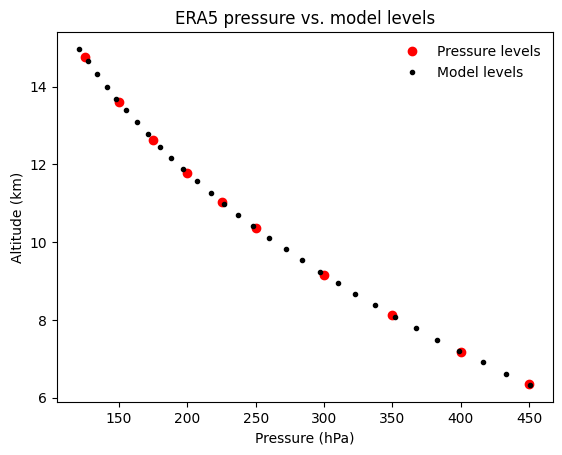

In [10]:
import matplotlib.pyplot as plt

plt.plot(
    met_pl["air_pressure"].data / 1e2, met_pl["altitude"].data / 1e3, "ro", label="Pressure levels"
)
plt.plot(
    met_ml["air_pressure"].data / 1e2, met_ml["altitude"].data / 1e3, "k.", label="Model levels"
)
plt.xlabel("Pressure (hPa)")
plt.ylabel("Altitude (km)")
plt.legend(frameon=False)
plt.title("ERA5 pressure vs. model levels")

## HRES

### Access

Users within ECMWF Member and Co-operating States may contact their Computing Representative to obtain access to MARS. 
All other users may [request a username and password](https://accounts.ecmwf.int/auth/realms/ecmwf/protocol/openid-connect/registrations?client_id=apps&response_type=code&scope=openid%20email&redirect_uri=https://www.ecmwf.int) and then [get an api key](https://api.ecmwf.int/v1/key/).

Provide `url`, `key`, and `email` credentials on input, or see [ECMWF API Client documentation](https://github.com/ecmwf/ecmwf-api-client#configure) to configure  local `~/.ecmwfapirc` file:

```json
{
    "url": "https://api.ecmwf.int/v1",
    "email": "<email>",
    "key": "<key>"
}
```

### Reference

- [HRES](https://confluence.ecmwf.int/display/FUG/Section+2.1.1.2+Rationale+for+High+Resolution) High resolution forecast
- [ENS](https://confluence.ecmwf.int/display/FUG/Section+2.1.2.1+ENS+-+Ensemble+Forecasts) Ensemble forecast

### HRES Pressure Levels

In [11]:
from datetime import datetime

from pycontrails.datalib.ecmwf import HRES

In [12]:
# NOTE / TODO: Including the "ciwc" variable here, the HRES request
# fails with on historic data. However, the request seems to go through
# when the time field is recent (within the last 48 hours?)
time = datetime(2022, 3, 26, 0), datetime(2022, 3, 26, 2)
hres = HRES(
    time=time,
    variables=["t", "q", "u", "v", "w", "z"],
    pressure_levels=[150, 200, 250, 300, 400],  # all available between 150 and 400 hPa
    grid=1,
    # url="https://api.ecmwf.int/v1",
    # key="<key>"
    # email="<email>"
)
hres

HRES
	Timesteps: ['2022-03-26 00', '2022-03-26 01', '2022-03-26 02']
	Variables: ['t', 'q', 'u', 'v', 'w', 'z']
	Pressure levels: [150, 200, 250, 300, 400]
	Grid: 1
	Forecast time: 2022-03-26 00:00:00
	Steps: [0, 1, 2]

In [13]:
# convience method to see the underlying MARS request
print(hres.generate_mars_request())

retrieve,
	class=od,
	stream=oper,
	expver=1,
	date=20220326,
	time=00,
	type=fc,
	param=t/q/u/v/w/z,
	step=0/1/2,
	grid=1/1,
	levtype=pl,
	levelist=150/200/250/300/400


In [14]:
# this triggers a download if file isn't in cache store
met_pl = hres.open_metdataset()
met_pl

MetDataset with data:

<xarray.Dataset> Size: 23MB
Dimensions:                              (longitude: 360, latitude: 181,
                                          level: 5, time: 3)
Coordinates:
    forecast_time                        datetime64[ns] 8B 2022-03-26
  * level                                (level) float64 40B 150.0 ... 400.0
  * latitude                             (latitude) float64 1kB -90.0 ... 90.0
  * time                                 (time) datetime64[ns] 24B 2022-03-26...
  * longitude                            (longitude) float64 3kB -180.0 ... 1...
    air_pressure                         (level) float32 20B 1.5e+04 ... 4e+04
    altitude                             (level) float32 20B 1.361e+04 ... 7....
Data variables:
    air_temperature                      (longitude, latitude, level, time) float32 4MB dask.array<chunksize=(360, 181, 5, 1), meta=np.ndarray>
    specific_humidity                    (longitude, latitude, level, time) float32 4MB dask.array<chunksize=(360, 181, 5, 1), meta=np.ndarray>
    eastward_wind                        (longitude, latitude, level, time) float32 4MB dask.array<chunksize=(360, 181, 5, 1), meta=np.ndarray>
    northward_wind                       (longitude, latitude, level, time) float32 4MB dask.array<chunksize=(360, 181, 5, 1), meta=np.ndarray>
    lagrangian_tendency_of_air_pressure  (longitude, latitude, level, time) float32 4MB dask.array<chunksize=(360, 181, 5, 1), meta=np.ndarray>
    geopotential                         (longitude, latitude, level, time) float32 4MB dask.array<chunksize=(360, 181, 5, 1), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-04-17T23:18 GRIB to CDM+CF via cfgrib-0.9.1...
    pycontrails_version:     0.50.1.dev19
    provider:                ECMWF
    dataset:                 HRES
    product:                 forecast
    radiation_accumulated:   True

### HRES Single Level

> Note that accumulated parameters (i.e. `top_net_thermal_radiation`, `toa_incident_solar_radiation` and other radiation parameters) are accumulated from the *start of the forecast*

In [15]:
hres = HRES(
    time=time,
    variables=["tsr", "ttr"],
    grid=1,
    # url="https://api.ecmwf.int/v1",
    # key="<key>"
    # email="<email>"
)

In [16]:
met = hres.open_metdataset()
met

MetDataset with data:

<xarray.Dataset> Size: 2MB
Dimensions:                    (level: 1, time: 3, latitude: 181, longitude: 360)
Coordinates:
  * level                      (level) float64 8B -1.0
    forecast_time              datetime64[ns] 8B 2022-03-26
    surface                    float64 8B 0.0
  * latitude                   (latitude) float64 1kB -90.0 -89.0 ... 89.0 90.0
  * time                       (time) datetime64[ns] 24B 2022-03-26 ... 2022-...
  * longitude                  (longitude) float64 3kB -180.0 -179.0 ... 179.0
Data variables:
    top_net_solar_radiation    (longitude, latitude, level, time) float32 782kB dask.array<chunksize=(360, 181, 1, 1), meta=np.ndarray>
    top_net_thermal_radiation  (longitude, latitude, level, time) float32 782kB dask.array<chunksize=(360, 181, 1, 1), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-04-17T23:19 GRIB to CDM+CF via cfgrib-0.9.1...
    pycontrails_version:     0.50.1.dev19
    provider:                ECMWF
    dataset:                 HRES
    product:                 forecast
    radiation_accumulated:   True

#### Specify forecast by runtime

Select data from specific forecast run by `forecast_time`

In [17]:
hres = HRES(
    time=("2022-03-26 01:00:00", "2022-03-26 02:00:00"),
    variables=["t", "q"],
    pressure_levels=[300, 250, 200],
    forecast_time="2022-03-25 12:00:00",
    # url="https://api.ecmwf.int/v1",
    # key="<key>"
    # email="<email>"
)
hres

HRES
	Timesteps: ['2022-03-26 01', '2022-03-26 02']
	Variables: ['t', 'q']
	Pressure levels: [200, 250, 300]
	Grid: 0.25
	Forecast time: 2022-03-25 12:00:00
	Steps: [13, 14]

### HRES Model Levels

- [Operational Archive Catalog](https://apps.ecmwf.int/archive-catalogue/?stream=oper&levtype=ml&time=00%3A00%3A00&expver=1&month=jan&year=2024&date=2024-01-01&type=fc&class=od)

In [18]:
from pycontrails.datalib.ecmwf import ModelLevelHRES

Similar to the model-level ERA5 demo, we download at a relatively coarse horizontal resolution to decrease data volume, and explicitly provide pressure levels to avoid upstream failures if the ECMWF model level webpage goes down.

As in the pressure- and single-level interfaces, we can explicitly specify the forecast time; if we do not, it defaults to the most recent forecast that includes the requested times.

In [19]:
hres = ModelLevelHRES(
    time=("2022-03-26 01:00:00", "2022-03-26 02:00:00"),
    variables=["t", "q"],
    forecast_time="2022-03-25 12:00:00",
    pressure_levels=[
        121,
        127,
        134,
        141,
        148,
        155,
        163,
        171,
        180,
        188,
        197,
        207,
        217,
        227,
        237,
        248,
        260,
        272,
        284,
        297,
        310,
        323,
        337,
        352,
        367,
        383,
        399,
        416,
        433,
        451,
    ],
    grid=1.0,
)
hres

ModelLevelHRES
	Timesteps: ['2022-03-26 01', '2022-03-26 02']
	Variables: ['t', 'q']
	Pressure levels: [121, 127, 134, 141, 148, 155, 163, 171, 180, 188, 197, 207, 217, 227, 237, 248, 260, 272, 284, 297, 310, 323, 337, 352, 367, 383, 399, 416, 433, 451]
	Grid: 1.0
	stream: 'oper'
	field type: 'fc'

In [20]:
met_ml = hres.open_metdataset()
met_ml

MetDataset with data:

<xarray.Dataset> Size: 31MB
Dimensions:              (longitude: 360, latitude: 181, level: 30, time: 2)
Coordinates:
    initialization_time  datetime64[ns] 8B 2022-03-25T12:00:00
  * time                 (time) datetime64[ns] 16B 2022-03-26T01:00:00 2022-0...
  * level                (level) float64 240B 121.0 127.0 134.0 ... 433.0 451.0
  * latitude             (latitude) float64 1kB -90.0 -89.0 -88.0 ... 89.0 90.0
    valid_time           (time) datetime64[ns] 16B 2022-03-26T01:00:00 2022-0...
  * longitude            (longitude) float64 3kB -180.0 -179.0 ... 178.0 179.0
    air_pressure         (level) float32 120B 1.21e+04 1.27e+04 ... 4.51e+04
    altitude             (level) float32 120B 1.497e+04 1.466e+04 ... 6.328e+03
Data variables:
    air_temperature      (longitude, latitude, level, time) float32 16MB dask.array<chunksize=(360, 181, 30, 1), meta=np.ndarray>
    specific_humidity    (longitude, latitude, level, time) float32 16MB dask.array<chunksize=(360, 181, 30, 1), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-04-17T23:20 GRIB to CDM+CF via cfgrib-0.9.1...
    pycontrails_version:     0.50.1.dev19
    provider:                ECMWF
    dataset:                 HRES
    product:                 forecast
    radiation_accumulated:   True

Text(0.5, 1.0, 'HRES pressure vs. model levels')

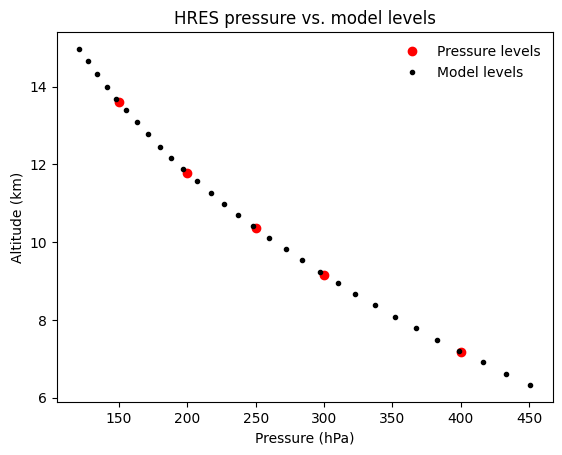

In [21]:
plt.plot(
    met_pl["air_pressure"].data / 1e2, met_pl["altitude"].data / 1e3, "ro", label="Pressure levels"
)
plt.plot(
    met_ml["air_pressure"].data / 1e2, met_ml["altitude"].data / 1e3, "k.", label="Model levels"
)
plt.xlabel("Pressure (hPa)")
plt.ylabel("Altitude (km)")
plt.legend(frameon=False)
plt.title("HRES pressure vs. model levels")

## IFS

> In development

Integrated Forecasting System from ECMWF

- [IFS Documentation](https://www.ecmwf.int/en/publications/ifs-documentation)

### Access

IFS files must be downloaded to a local directory before accessing.

### Reference

- [IFS Confluence](https://confluence.ecmwf.int/display/FUG/Section+2+The+ECMWF+Integrated+Forecasting+System+-+IFS)

In [22]:
from pycontrails.datalib.ecmwf import IFS

In [23]:
ifs = IFS(
    time=("2021-10-02 00:00:00", "2021-10-02 14:00:00"),
    variables=["air_temperature"],
    forecast_path="ifs",
    forecast_date="2021-10-01",
)

## ECMWF Variables

`ECMWF_VARIABLES` attribute lists the supported parameters from the [ECMWF Pameter DB](https://apps.ecmwf.int/codes/grib/param-db) as a `list[MetVariable]`

In [24]:
from pycontrails.datalib.ecmwf import ECMWF_VARIABLES

In [25]:
[met_var.standard_name for met_var in ECMWF_VARIABLES]

['air_temperature',
 'specific_humidity',
 'geopotential',
 'eastward_wind',
 'northward_wind',
 'lagrangian_tendency_of_air_pressure',
 'relative_humidity',
 'atmosphere_upward_relative_vorticity',
 'fraction_of_cloud_cover',
 'specific_cloud_ice_water_content',
 'specific_cloud_liquid_water_content',
 'potential_vorticity',
 'surface_air_pressure',
 'toa_incident_solar_radiation',
 'top_net_solar_radiation',
 'top_net_thermal_radiation',
 'total_cloud_cover',
 'surface_solar_downward_radiation']

In [26]:
from pycontrails.datalib.ecmwf import TopNetSolarRadiation

In [27]:
# ECMWF variables contain a link to the param-db entry
TopNetSolarRadiation.ecmwf_link

'https://apps.ecmwf.int/codes/grib/param-db?id=178'

## Cache Data Files to GCP

> Requires `[gcp]` optional dependencies:
>
> ```
> $ pip install pycontrails[gcp]
> ```

By default, data files are cached to the local disk in the users `Caches` directory.

To cache files to a remote Google Cloud Storage bucket, use the `GCPCacheStore`

### ERA5

In [28]:
from pycontrails import GCPCacheStore

In [29]:
variables = ["air_temperature", "relative_humidity"]

gcp = GCPCacheStore(bucket="contrails-301217-unit-test", cache_dir="test/era5", read_only=False)

era5 = ERA5(
    time=(datetime(2019, 1, 1, 0), datetime(2019, 1, 1, 2)),
    variables=variables,
    pressure_levels=[300, 250, 150],
    cachestore=gcp,
    # url="https://cds.climate.copernicus.eu/api/v2",
    # key="<key>"
)

In [30]:
# download data to cache - uncomment to run
# met = era5.open_metdataset()